In [1]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal
from raster_tools.dtypes import F32, U8

import matplotlib.pyplot as plt

In [2]:
# change pandas max col display
pd.set_option('display.max_columns', 500)

In [3]:
# Location for temporary storage
TMP_LOC = "/home/jake/FireLab/Project/data/temp/"
DATA_LOC = "/home/jake/FireLab/Project/data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs.parquet")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")

PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986_2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1986_2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    "biomass_afg": pjoin(
        FEATURE_DIR, "biomass/biomass_afg_1986_2020_{}.nc".format(STATE)
    ),
    "biomass_pfg": pjoin(
        FEATURE_DIR, "biomass/biomass_pfg_1986_2020_{}.nc".format(STATE)
    ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = list(range(1986, 2021))
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS))
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS))
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS))
BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS))
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS))
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS))
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))

---

## MTBS DATASET INFO

In [4]:
df = dgpd.read_parquet(mtbs_df_temp_path)
df.head()

,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year
0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,76,1986
1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,187,1986
2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,133,1986
3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2080.0,122.0,63,1986
4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2123.0,122.0,181,1986


In [5]:
mtbs_dataset = df.compute()

In [6]:
# adds unique id to each pixel
mtbs_dataset.reset_index(inplace=True)
mtbs_dataset['index'] = mtbs_dataset.index
# rename index to unique_id
mtbs_dataset.rename(columns={'index': 'unique_id'}, inplace=True)
mtbs_dataset

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year
0,0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,76.0,1986
1,1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,187.0,1986
2,2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,133.0,1986
3,3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2080.0,122.0,63.0,1986
4,4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,181.0,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55328727,55328727,1,POINT (-1697400.000 2447790.000),OR,2020-11-05,1528.0,15.068486,83.439735,47.0,-12.428667,-21.412666,579.0,558.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,141.0,2020
55328728,55328728,1,POINT (-1697370.000 2447790.000),OR,2020-11-05,1521.0,14.851972,84.313797,48.0,-12.428667,-21.412666,710.0,332.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,142.0,2020
55328729,55328729,1,POINT (-1697490.000 2447760.000),OR,2020-11-05,1513.0,14.268291,85.838928,49.0,-12.428667,-21.412666,753.0,400.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,143.0,2020
55328730,55328730,1,POINT (-1697460.000 2447760.000),OR,2020-11-05,1506.0,12.509232,89.095985,50.0,-12.428667,-21.412666,701.0,481.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,146.0,2020


In [7]:
# # rewrite to parquet
# mtbs_dataset.to_parquet(mtbs_df_path)

In [8]:
# mtbs_dataset['geometry'] = mtbs_dataset['geometry'].apply(lambda geom: geom.wkt)
# dask_mtbs_dataset = dgpd.from_geopandas(mtbs_dataset, npartitions=100)
# dask_mtbs_dataset = dask_mtbs_dataset.repartition(partition_size="100MB")
# dask_mtbs_dataset.to_parquet(mtbs_df_path, engine="pyarrow")

In [9]:
# # a function to round numeric values in a dataframe to 3 decimals (if they are > 1)
# def round_df(df):
#     columns_to_round = ['aw_mwmt', 'dm_tmax', 'dm_tmin', 'gm_srad', 'gm_vpd', 'aw_td', 'aw_mcmt', 'dem_aspect', 'dem_slope']
#     for col in columns_to_round:
#         df[col] = df[col].round(3)
#     return df

In [10]:
# load mtbs perimeters
print("Loading MTBS perimeters")
mtbs_perim = gpd.read_file(PATHS["mtbs_perim"])
mtbs_perim.columns

Loading MTBS perimeters


Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')

In [11]:
# extract only the columns we need (Event_ID where startswith OR, Ig_Date, and geometry)
mtbs_perim = mtbs_perim[["Event_ID", "Ig_Date", "geometry"]]
mtbs_perim = mtbs_perim[mtbs_perim.Event_ID.str.startswith("OR")]
mtbs_perim.reset_index(drop=True, inplace=True)
mtbs_perim

,Event_ID,Ig_Date,geometry
0,OR4229711891819840628,1984-06-28,"POLYGON ((-118.91708 42.30802, -118.91694 42.3..."
1,OR4283811911619840709,1984-07-09,"POLYGON ((-119.11184 42.86765, -119.11242 42.8..."
2,OR4313011879219840726,1984-07-26,"POLYGON ((-118.82246 43.11462, -118.82233 43.1..."
3,OR4300911815919840804,1984-08-04,"MULTIPOLYGON (((-118.16605 43.03833, -118.1657..."
4,OR4276411926519840804,1984-08-04,"POLYGON ((-119.27257 42.78405, -119.27237 42.7..."
...,...,...,...
1056,OR4408911832220210803,2021-08-03,"POLYGON ((-118.32570 44.11534, -118.32575 44.1..."
1057,OR4346212260120210802,2021-08-02,"POLYGON ((-122.57635 43.47530, -122.57635 43.4..."
1058,OR4351412268220210727,2021-07-27,"POLYGON ((-122.59900 43.50128, -122.59894 43.5..."
1059,OR4402911868120211101,2021-11-01,"POLYGON ((-118.68120 44.06471, -118.68122 44.0..."


In [13]:
mtbs_dataset['Fire_ID'] = 'None'
mtbs_dataset

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year,Fire_ID
0,0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,76.0,1986,None
1,1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,187.0,1986,None
2,2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,133.0,1986,None
3,3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2080.0,122.0,63.0,1986,None
4,4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,181.0,1986,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55328727,55328727,1,POINT (-1697400.000 2447790.000),OR,2020-11-05,1528.0,15.068486,83.439735,47.0,-12.428667,-21.412666,579.0,558.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,141.0,2020,None
55328728,55328728,1,POINT (-1697370.000 2447790.000),OR,2020-11-05,1521.0,14.851972,84.313797,48.0,-12.428667,-21.412666,710.0,332.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,142.0,2020,None
55328729,55328729,1,POINT (-1697490.000 2447760.000),OR,2020-11-05,1513.0,14.268291,85.838928,49.0,-12.428667,-21.412666,753.0,400.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,143.0,2020,None
55328730,55328730,1,POINT (-1697460.000 2447760.000),OR,2020-11-05,1506.0,12.509232,89.095985,50.0,-12.428667,-21.412666,701.0,481.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,146.0,2020,None


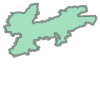

In [14]:
fire_perim_geom_or45868_ = mtbs_perim.loc[1060, 'geometry']
fire_ig_date_or45868_ = mtbs_perim.loc[1060, 'Ig_Date']
fire_perim_geom_or45868_

In [26]:
# convert the geometry in mtbs_dataset to lat lon
mtbs_dataset = mtbs_dataset.to_crs(epsg=4326)
mtbs_perim = mtbs_perim.to_crs(epsg=4326)

In [27]:
# get a ignition point from a fire in mtbs_dataset
fire_point_geom_or45868_ = mtbs_dataset.loc[0, 'geometry']

# see if the point is within any perimeter from mtbs_perim
mtbs_perim[mtbs_perim.geometry.contains(fire_point_geom_or45868_)]

,Event_ID,Ig_Date,geometry


In [15]:
# # for each fire in mtbs_perim, find the pixels that intersect with the fire perimeter and set their Fire_ID to the fire's Event_ID, will also have to match on ig_date (mtbs_dataset) and Ig_Date (mtbs_perim)
# for index, row in tqdm.tqdm(mtbs_perim.iterrows(), total=len(mtbs_perim)):
#     fire_id = row.Event_ID
#     fire_geom = row.geometry
#     ig_date = row.Ig_Date
#     print(mtbs_dataset.loc[(mtbs_dataset.geometry.intersects(fire_geom)) & (mtbs_dataset.ig_date == ig_date)])
#     mtbs_dataset.loc[(mtbs_dataset.geometry.intersects(fire_geom)) & (mtbs_dataset.ig_date == ig_date), 'Fire_ID'] = fire_id

# mtbs_dataset
